In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import joblib # Pour sauvegarder notre modèle

print("Librairies importées avec succès.")

Librairies importées avec succès.


In [36]:
# Chemin vers notre dataset
# Il est dans le dossier 'data' à côté de ce notebook
DATASET_PATH = 'data/dataset_absences.csv'

# Charger les données dans un DataFrame Pandas
df = pd.read_csv(DATASET_PATH)

print(f"Dataset chargé avec succès. Il contient {len(df)} lignes et {len(df.columns)} colonnes.")
print("\nTypes de données :")
df.info()

print("\nCinq premières lignes du dataset :")
df.head()

Dataset chargé avec succès. Il contient 6734 lignes et 12 colonnes.

Types de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6734 entries, 0 to 6733
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   employe_id        6734 non-null   int64 
 1   date              6734 non-null   object
 2   jour_semaine      6734 non-null   int64 
 3   jour_mois         6734 non-null   int64 
 4   mois              6734 non-null   int64 
 5   semaine_annee     6734 non-null   int64 
 6   profil_metier_id  6734 non-null   int64 
 7   noeud_id          6734 non-null   int64 
 8   est_ferie         6734 non-null   int64 
 9   veille_ferie      6734 non-null   int64 
 10  lendemain_ferie   6734 non-null   int64 
 11  est_absent        6734 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 631.4+ KB

Cinq premières lignes du dataset :


,employe_id,date,jour_semaine,jour_mois,mois,semaine_annee,profil_metier_id,noeud_id,est_ferie,veille_ferie,lendemain_ferie,est_absent
0,1,2023-07-24,0,24,7,30,67,27,0,0,0,0
1,1,2023-07-25,1,25,7,30,67,27,0,0,0,0
2,1,2023-07-26,2,26,7,30,67,27,0,0,0,0
3,1,2023-07-27,3,27,7,30,67,27,0,0,0,0
4,1,2023-07-28,4,28,7,30,67,27,0,0,0,0


In [37]:
# Définir la colonne cible (ce qu'on veut prédire)
TARGET_COLUMN = 'est_absent'

# Définir les colonnes de features (tout SAUF la cible et les identifiants)
# On exclut 'employe_id' et 'date' car ce ne sont pas des caractéristiques pour le modèle,
# mais des identifiants.
FEATURES_COLUMNS = [col for col in df.columns if col not in [TARGET_COLUMN, 'employe_id', 'date']]

# Créer nos matrices X et y
X = df[FEATURES_COLUMNS]
y = df[TARGET_COLUMN]

print("Colonnes de Features (X):")
print(X.columns.tolist())
print(f"\nDimensions de X: {X.shape}")

print("\nColonne Cible (y):")
print(y.name)
print(f"Dimensions de y: {y.shape}")

Colonnes de Features (X):
['jour_semaine', 'jour_mois', 'mois', 'semaine_annee', 'profil_metier_id', 'noeud_id', 'est_ferie', 'veille_ferie', 'lendemain_ferie']

Dimensions de X: (6734, 9)

Colonne Cible (y):
est_absent
Dimensions de y: (6734,)


In [38]:
# Séparer le dataset en 80% pour l'entraînement et 20% pour le test
# stratify=y est très important : il s'assure qu'on a la même proportion
# d'absents et de non-absents dans les deux sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, # Pour que le résultat soit reproductible
    stratify=y
)

print(f"Taille du set d'entraînement (X_train): {X_train.shape}")
print(f"Taille du set de test (X_test): {X_test.shape}")

Taille du set d'entraînement (X_train): (5387, 9)
Taille du set de test (X_test): (1347, 9)


In [39]:
# REMPLACE TOUT LE CONTENU DE LA CELLULE 5 PAR CECI

print("--- Étape 5: Entraînement du modèle LightGBM ---")

# Calculer le ratio pour le déséquilibre de classe
# C'est une méthode plus robuste que 'balanced'
count_neg, count_pos = y_train.value_counts()
scale_pos_weight_value = count_neg / count_pos
print(f"Ratio pour le rééquilibrage (scale_pos_weight): {scale_pos_weight_value:.2f}")


# Créer une instance du classificateur LightGBM
model = LGBMClassifier(
    objective='binary',
    n_estimators=100,
    random_state=42,
    scale_pos_weight=scale_pos_weight_value # <-- On utilise cette option puissante
)

# Entraîner le modèle sur les données D'ORIGINE (pas besoin de SMOTE avec cette méthode)
# .fit() signifie "ajuster" ou "apprendre".
model.fit(X_train, y_train)

print("\nEntraînement terminé !")

--- Étape 5: Entraînement du modèle LightGBM ---
Ratio pour le rééquilibrage (scale_pos_weight): 64.70
[LightGBM] [Info] Number of positive: 82, number of negative: 5305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 5387, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015222 -> initscore=-4.169686
[LightGBM] [Info] Start training from score -4.169686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Entraînement terminé !


--- Étape 6: Évaluation du modèle sur le set de test ---

Rapport de Classification :

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1326
           1       0.15      0.33      0.21        21

    accuracy                           0.96      1347
   macro avg       0.57      0.65      0.59      1347
weighted avg       0.98      0.96      0.97      1347


Matrice de Confusion :


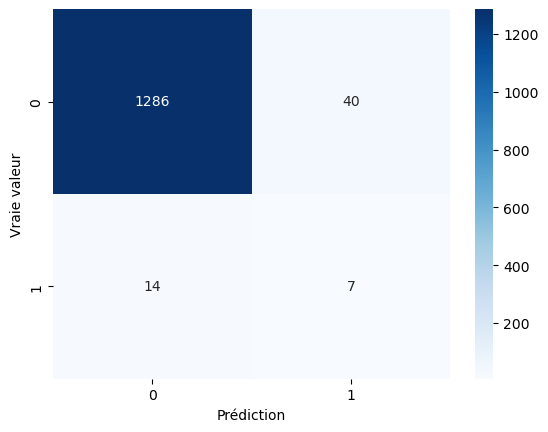

In [40]:
print("--- Étape 6: Évaluation du modèle sur le set de test ---")

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Afficher le rapport de classification
# C'est le résumé le plus complet de la performance
print("\nRapport de Classification :\n")
print(classification_report(y_test, y_pred))

# Afficher la matrice de confusion
# C'est une visualisation très utile
print("\nMatrice de Confusion :")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

In [41]:
print("--- Étape 7: Sauvegarde du modèle entraîné ---")

# Définir le chemin où sauvegarder le modèle
# On le met dans le dossier 'models' que tu as déjà.
MODEL_PATH = '../models/absence_predictor_model.pkl'

# Sauvegarder l'objet 'model' dans le fichier
joblib.dump(model, MODEL_PATH)

print(f"\nModèle sauvegardé avec succès dans : {MODEL_PATH}")

# Vérification (optionnelle) : on essaie de le recharger pour être sûr
loaded_model = joblib.load(MODEL_PATH)
print("\nModèle rechargé avec succès pour vérification.")
print(loaded_model)

--- Étape 7: Sauvegarde du modèle entraîné ---

Modèle sauvegardé avec succès dans : ../models/absence_predictor_model.pkl

Modèle rechargé avec succès pour vérification.
LGBMClassifier(objective='binary', random_state=42,
               scale_pos_weight=64.6951219512195)
